> ## **Setup**

In [1]:
# !pip install numpy pandas tqdm pillow scikit-learn scikit-image matplotlib seaborn torchmetrics opencv-python

In [3]:
import os, random, glob, cv2, torch
from pathlib import Path
from enum import Enum
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import transforms

# --- Metrics & evaluation ---
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score,
)

# --- Reproducibility ---
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

In [4]:
# Traffic sign classes aligned with GTSRB (0–42)
class TrafficSignClass(Enum):
    SPEED_LIMIT_20 = "Speed limit (20km/h)"
    SPEED_LIMIT_30 = "Speed limit (30km/h)"
    SPEED_LIMIT_50 = "Speed limit (50km/h)"
    SPEED_LIMIT_60 = "Speed limit (60km/h)"
    SPEED_LIMIT_70 = "Speed limit (70km/h)"
    SPEED_LIMIT_80 = "Speed limit (80km/h)"
    END_SPEED_LIMIT_80 = "End of speed limit (80km/h)"
    SPEED_LIMIT_100 = "Speed limit (100km/h)"
    SPEED_LIMIT_120 = "Speed limit (120km/h)"
    NO_PASSING = "No passing"
    NO_PASSING_VEH_OVER_3_5_TONS = "No passing veh over 3.5 tons"
    RIGHT_OF_WAY_AT_INTERSECTION = "Right-of-way at intersection"
    PRIORITY_ROAD = "Priority road"
    YIELD = "Yield"
    STOP = "Stop"
    NO_VEHICLES = "No vehicles"
    VEH_OVER_3_5_TONS_PROHIBITED = "Veh > 3.5 tons prohibited"
    NO_ENTRY = "No entry"
    GENERAL_CAUTION = "General caution"
    DANGEROUS_CURVE_LEFT = "Dangerous curve left"
    DANGEROUS_CURVE_RIGHT = "Dangerous curve right"
    DOUBLE_CURVE = "Double curve"
    BUMPY_ROAD = "Bumpy road"
    SLIPPERY_ROAD = "Slippery road"
    ROAD_NARROWS_ON_THE_RIGHT = "Road narrows on the right"
    ROAD_WORK = "Road work"
    TRAFFIC_SIGNALS = "Traffic signals"
    PEDESTRIANS = "Pedestrians"
    CHILDREN_CROSSING = "Children crossing"
    BICYCLES_CROSSING = "Bicycles crossing"
    BEWARE_OF_ICE_SNOW = "Beware of ice/snow"
    WILD_ANIMALS_CROSSING = "Wild animals crossing"
    END_SPEED_PASSING_LIMITS = "End speed + passing limits"
    TURN_RIGHT_AHEAD = "Turn right ahead"
    TURN_LEFT_AHEAD = "Turn left ahead"
    AHEAD_ONLY = "Ahead only"
    GO_STRAIGHT_OR_RIGHT = "Go straight or right"
    GO_STRAIGHT_OR_LEFT = "Go straight or left"
    KEEP_RIGHT = "Keep right"
    KEEP_LEFT = "Keep left"
    ROUNDABOUT_MANDATORY = "Roundabout mandatory"
    END_NO_PASSING = "End of no passing"
    END_NO_PASSING_VEH_OVER_3_5_TONS = "End no passing veh > 3.5 tons"

In [5]:
"""
Create mapping: index -> class name
0  → "Speed limit (20km/h)" ,
1  → "Speed limit (30km/h)" , etc.
This will help to convert from number to sign name after model output
"""
IDX_TO_CLASS = {i: sign.value for i, sign in enumerate(TrafficSignClass)}


"""
Create reverse mapping: class name -> index
"Stop" → 14 (label)
"""
CLASS_TO_IDX = {sign.value: i for i, sign in enumerate(TrafficSignClass)}


# Helper function
def get_class_name(idx: int) -> str:
    """Get class name from index."""
    return IDX_TO_CLASS.get(idx, "Unknown")


def get_class_idx(name: str) -> int:
    """Get class index from name."""
    return CLASS_TO_IDX.get(name, -1)

> ## **Pre-Processing**

In [6]:
class PreProcess:
    def __init__(self, size=(64, 64), to_grayscale=False, normalize="minmax", apply_threshold=True, threshold_method="otsu"):
        self.size = size
        self.to_grayscale = to_grayscale
        self.normalize_method = normalize
        self.apply_threshold = apply_threshold
        self.threshold_method = threshold_method

    def resize_image(self, image):
        return cv2.resize(image, self.size)

    def convert_to_grayscale(self, image):
        if len(image.shape) == 3:
            return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        return image

    def reduce_noise(self, image):
        return cv2.GaussianBlur(image, (5, 5), 0)

    def enhance_contrast(self, image):
        if len(image.shape) == 3:
            lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
            l, a, b = cv2.split(lab)
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            cl = clahe.apply(l)
            lab = cv2.merge((cl, a, b))
            image = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        return image

    def brighten_image(self, image, alpha=1.0, beta=50):
        gray = self.convert_to_grayscale(image)
        if np.mean(gray) < 100:
            image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
        return image

    def apply_thresholding(self, image):
        if len(image.shape) == 3:
            image = self.convert_to_grayscale(image)

        if self.threshold_method == "otsu":
            _, result = cv2.threshold(
                image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
            )
        elif self.threshold_method == "adaptive_mean":
            result = cv2.adaptiveThreshold(
                image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, 5
            )
        elif self.threshold_method == "chow_kaneko":
            result = self._chow_kaneko_logic(image)
        elif self.threshold_method == "cheng_jin_kuo":
            result = self._cheng_jin_kuo_logic(image)
        else:
            result = image
        return result

    def _chow_kaneko_logic(self, image, block_size=15):
        rows, cols = image.shape
        result = np.zeros_like(image)
        for i in range(0, rows, block_size):
            for j in range(0, cols, block_size):
                block = image[i : i + block_size, j : j + block_size]
                if block.size == 0:
                    continue
                threshold = np.mean(block)
                result[i : i + block_size, j : j + block_size] = (
                    block > threshold
                ).astype(np.uint8) * 255
        return result

    def _cheng_jin_kuo_logic(self, image, block_size=15, k=0.5):
        rows, cols = image.shape
        result = np.zeros_like(image)
        for i in range(0, rows, block_size):
            for j in range(0, cols, block_size):
                block = image[i : i + block_size, j : j + block_size]
                if block.size == 0:
                    continue
                threshold = np.mean(block) - k * np.std(block)
                result[i : i + block_size, j : j + block_size] = (
                    block > threshold
                ).astype(np.uint8) * 255
        return result

    def canny_and_thickening(self, binary_img, low_threshold=50, high_threshold=150):
        edges = cv2.Canny(binary_img, low_threshold, high_threshold)
        kernel = np.ones((2, 2), np.uint8)
        image = cv2.dilate(edges, kernel, iterations=1)
        return image

    def normalize_image(self, image):
        if self.normalize_method == "minmax":
            return image.astype(np.float32) / 255.0
        return image

    def __call__(self, image):
        image = self.resize_image(image)
        image = self.brighten_image(image)
        image = self.enhance_contrast(image)
        image = self.reduce_noise(image)
        if self.apply_threshold:
            image = self.apply_thresholding(image)
        image = self.canny_and_thickening(image)
        image = self.normalize_image(image)
        return image

In [7]:
class ChainCodeExtractor:
    chain_code_direction_8 = {
        (0, 1): 0,      # Right
        (-1, 1): 1,     # Upper-right  (x+,y-)
        (-1, 0): 2,     # Up
        (-1, -1): 3,    # Upper-left
        (0, -1): 4,     # Left
        (1, -1): 5,     # Lower-left
        (1, 0): 6,      # Down
        (1, 1): 7,      # Lower-right
    }

    sharpening_kernel = np.array(
        [  # edges become more clear and sharp(High-pass filter)
            [0, -1, 0],
            [-1, 5, -1],
            [0, -1, 0],
        ]
    )

    @staticmethod
    def extract_chain_code(image, max_code_length=None):
        # 'image' here is the float32 edge map from PreProcess (0 to 1 range)
        # Convert it to a uint8 binary image (0 or 255) suitable for findContours.
        binary_img = (image * 255).astype(np.uint8)

        # Find contours
        contours, _ = cv2.findContours(
            binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
        )  # RETR_EXTERNAL(Contour Retrieval Mode) -> i need the outer contour , CHAIN_APPROX_NONE(Contour Approximation Method) get all points of contour not to delete of them to avoid not good contours
        if not contours:
            return None

        largest_contour = max(
            contours, key=cv2.contourArea
        )  # if there is noise -> get the bigger shape
        chain_codes = []

        for i in range(1, len(largest_contour)):
            prev, curr = largest_contour[i - 1][0], largest_contour[i][0]
            dx, dy = curr[0] - prev[0], curr[1] - prev[1]
            direction = ChainCodeExtractor.chain_code_direction_8.get((dx, dy))
            if direction is not None:
                chain_codes.append(direction)

        # Fix length
        if max_code_length:  # all with the same length
            if len(chain_codes) < max_code_length:
                chain_codes += [0] * (
                    max_code_length - len(chain_codes)
                )  # padding with 0
            else:
                chain_codes = chain_codes[:max_code_length]  # truncation

        return chain_codes, binary_img, largest_contour

    @staticmethod
    def process_images(images, preprocessor, num_samples_to_show=5):
        features = []
        max_code_length = 0
        all_processed_imgs = []

        for img in tqdm(images, desc="Phase 1: Preprocessing"):
            processed_img = preprocessor(img)
            all_processed_imgs.append(processed_img)

            res = ChainCodeExtractor.extract_chain_code(processed_img)
            if res:
                max_code_length = max(max_code_length, len(res[0]))

        for idx, proc_img in enumerate(
            tqdm(all_processed_imgs, desc="Phase 2: Extracting Chain Codes")
        ):
            result = ChainCodeExtractor.extract_chain_code(proc_img, max_code_length)

            if result:
                chain_codes, binary_img, contour = result
                features.append(chain_codes)

                if idx < num_samples_to_show:
                    plt.figure(figsize=(10, 4))
                    plt.subplot(1, 2, 1)
                    plt.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))
                    plt.title(f"Original {idx+1}")
                    plt.axis("off")

                    plt.subplot(1, 2, 2)
                    plt.imshow(binary_img, cmap="gray")
                    plt.plot(contour[:, 0, 0], contour[:, 0, 1], "r-", lw=2)
                    plt.title("Processed & Contour")
                    plt.axis("off")
                    plt.show()

        return np.array(features)

Phase 2: Extracting Chain Codes:   0%|          | 0/1 [00:00<?, ?it/s]

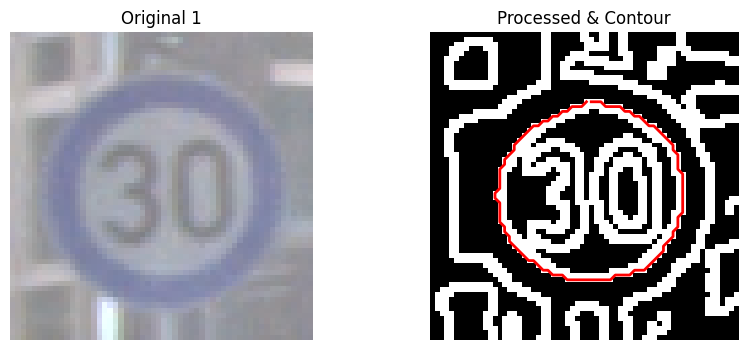

Phase 2: Extracting Chain Codes: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]

----------------------------------------
Extracted Features:
 [[1 2 2 1 2 1 2 1 2 1 2 1 1 1 1 0 1 1 0 1 0 0 0 0 1 0 7 0 0 0 0 7 0 7 0 7
  7 7 7 6 7 7 6 7 6 6 7 6 6 6 6 6 6 6 6 6 5 6 6 6 5 6 6 5 5 5 5 4 5 5 4 5
  4 4 5 4 4 4 4 4 4 4 4 3 4 4 4 3 4 3 3 3 3 2 3 3 2 3 2 3 2 2 2 3 2 2]]


In [8]:
def check_preprocessor(image):
    if image is None:
        print("Error: Image not found. Check the path!")
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for consistent display
        # Instantiate the PreProcess class
        preprocessor = PreProcess()
        features = ChainCodeExtractor.process_images([image], preprocessor)
        print('-'*40)
        print("Extracted Features:\n", features)

# image_path = "../Data/Meta/29/00029_00005_00028.png"
image_path = "../Data/Train/1/00001_00000_00000.png"
image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load the image

check_preprocessor(image)

> ## **EDA**

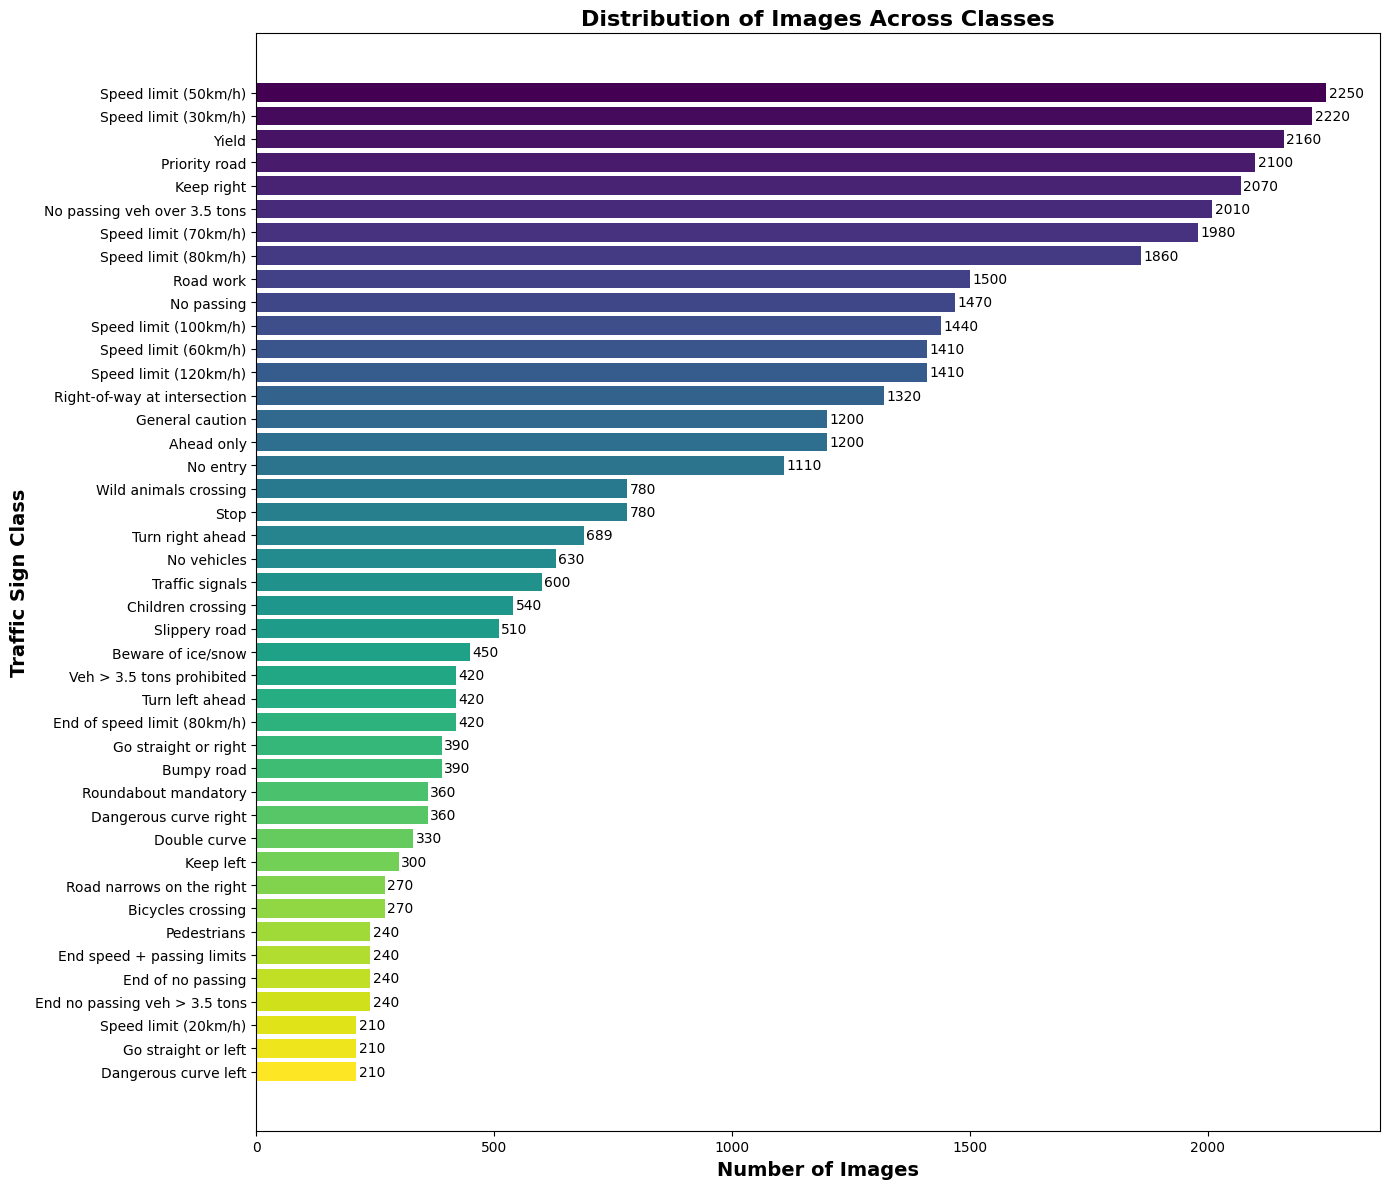

In [9]:
# Define paths
train_path = Path("../Data/Train")
folders = [folder for folder in train_path.iterdir() if folder.is_dir()]

train_number = []
class_num = []

# Collect number of images per class
for folder in folders:
    train_files = list(folder.iterdir())
    if train_files:  # Check if the folder is not empty
        train_number.append(len(train_files))
        class_num.append(
            IDX_TO_CLASS[int(folder.name)]
        )  # Map folder index to class name

# Sorting the dataset on the basis of number of images in each class (descending for barh)
sorted_pairs = sorted(zip(train_number, class_num), reverse=True)
train_number, class_num = zip(*sorted_pairs)

# Plotting as horizontal bar chart
plt.figure(figsize=(14, 12))
bars = plt.barh(class_num, train_number, color=plt.cm.viridis(np.linspace(0, 1, len(class_num))))

# Labels & Title
plt.xlabel("Number of Images", fontsize=14, weight="bold")
plt.ylabel("Traffic Sign Class", fontsize=14, weight="bold")
plt.title("Distribution of Images Across Classes", fontsize=16, weight="bold")

# Add values at the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 5,
        bar.get_y() + bar.get_height() / 2,
        str(width),
        va="center",
        fontsize=10,
    )

plt.gca().invert_yaxis()  # To show the largest class at the top
plt.tight_layout()
plt.show()

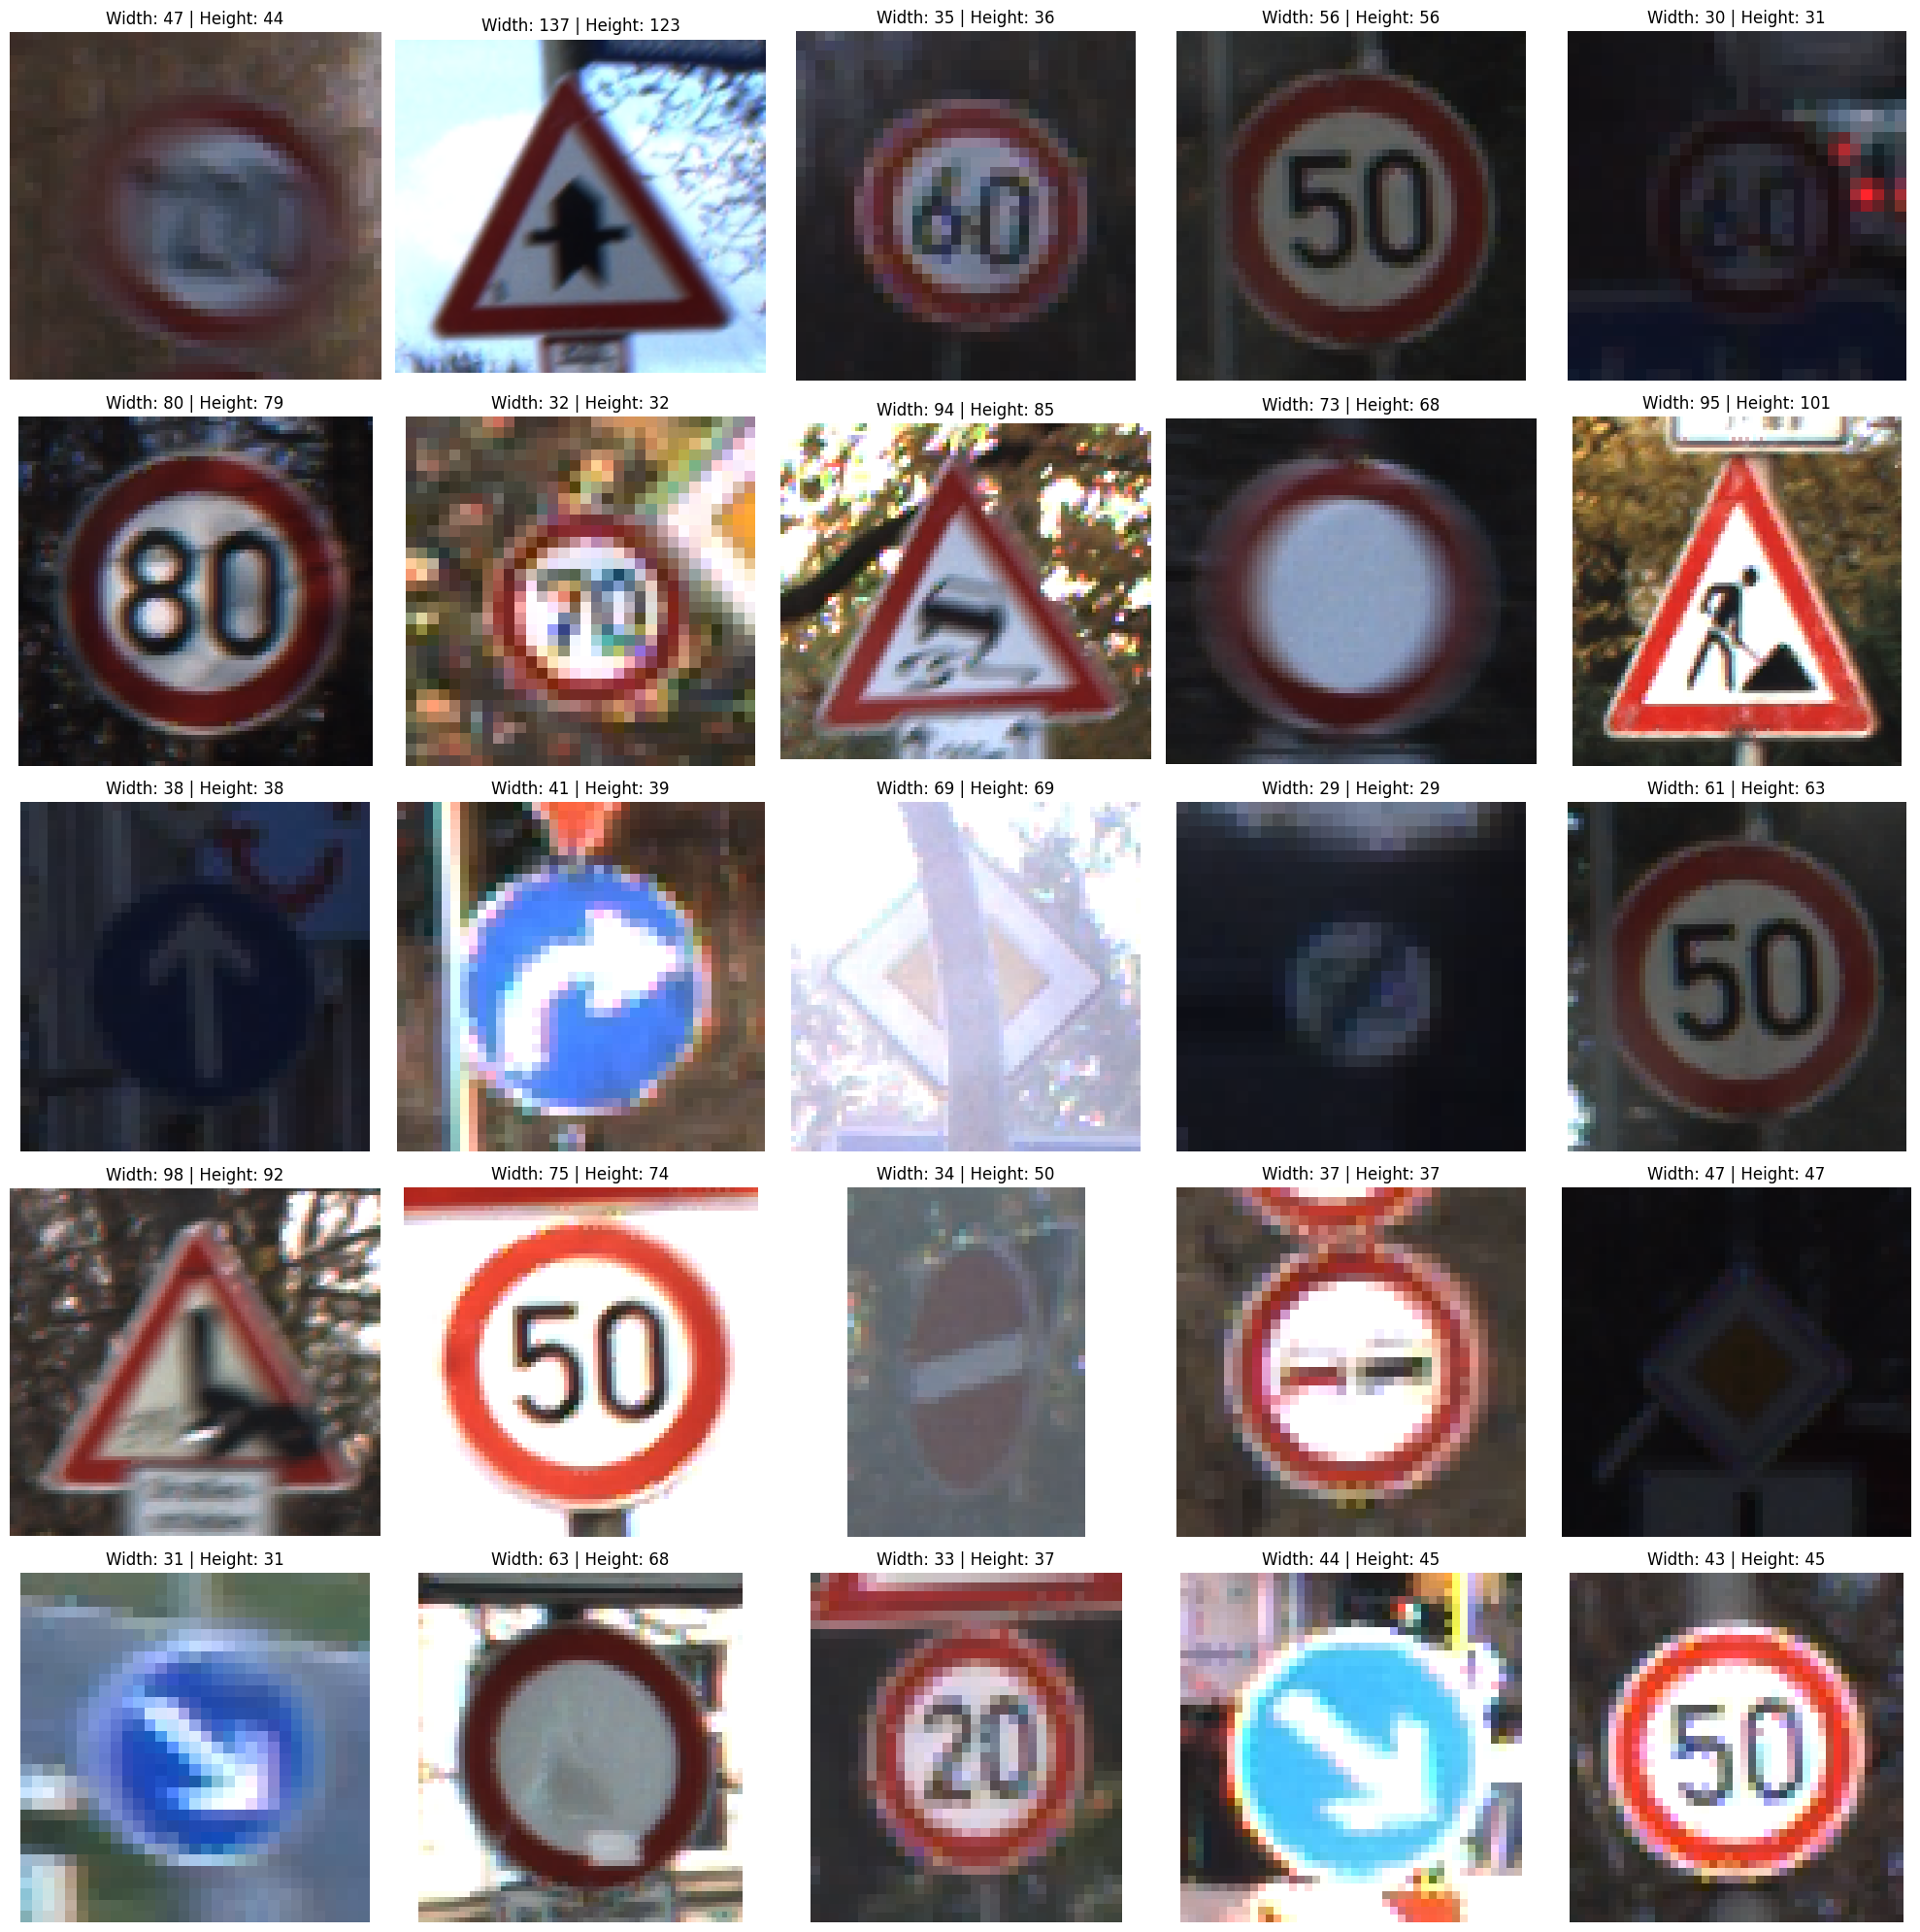

In [11]:
# Load the test data
test = pd.read_csv("../Data/Test.csv")
img_paths = test["Path"].values

# Define the base path
base_path = Path("../Data")

# Pick 25 unique random images
sampled_imgs = random.sample(list(img_paths), min(25, len(img_paths)))

# Display random 25 images from the test set
plt.figure(figsize=(20, 20))

for i, img_rel_path in enumerate(sampled_imgs, 1):
    # Correctly join base_path with the relative image path from the CSV
    img_path = base_path / img_rel_path

    if img_path.exists():
        img = imread(img_path)
        # Handle grayscale vs RGB
        if img.ndim == 2:
            cmap = "gray"
        else:
            cmap = None
        plt.subplot(5, 5, i)
        plt.imshow(img, cmap=cmap)
        plt.axis("off")
        plt.title(f"Width: {img.shape[1]} | Height: {img.shape[0]}", fontsize=12)
    else:
        print(f"Error: File {img_path} does not exist.")

plt.tight_layout()
plt.show()

> ## **Prepare Data**

In [12]:
num_classes = 43
image_size = (64, 64)  # (width, height)
# Initialize preprocessor
preprocessor = PreProcess(size=image_size, to_grayscale=False, normalize="minmax")

# Initialize lists for images and labels
images, labels = [], []

# Base training directory
base_path = Path("../Data/Train")

# Load and preprocess images
for class_label in tqdm(range(num_classes), desc="Loading and preprocessing data"):
    class_dir = base_path / str(class_label)
    if class_dir.is_dir():
        for img_file in glob.glob(str(class_dir / "*.*")):
            img = cv2.imread(img_file, cv2.IMREAD_COLOR)
            if img is not None:
                # Apply full preprocessing pipeline
                img = preprocessor(img)

                # If grayscale, expand dims to have channel=1
                if img.ndim == 2:
                    img = np.expand_dims(img, axis=2)

                # Convert HWC -> CHW
                img_tensor = torch.from_numpy(img).permute(2, 0, 1).float()
                images.append(img_tensor)
                labels.append(class_label)
            else:
                print(f"Warning: Could not read image {img_file}")

# Stack all tensors
images = torch.stack(images)
labels = torch.tensor(labels, dtype=torch.long)

# Normalize if not done inside PreProcess (already 0-1)
print(f"Images shape: {images.shape}")  # (N, C, H, W)
print(f"Labels shape: {labels.shape}")  # (N,)

Loading and preprocessing data: 100%|██████████| 43/43 [08:01<00:00, 11.20s/it]


Images shape: torch.Size([39209, 1, 64, 64])
Labels shape: torch.Size([39209])


In [13]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, shuffle=True)

# Ensure correct dtypes
X_train = X_train.float()
X_test  = X_test.float()
y_train = y_train.long()
y_test  = y_test.long()

# Wrap in TensorDataset for easy DataLoader usage
train_dataset = TensorDataset(X_train, y_train)
test_dataset  = TensorDataset(X_test, y_test)

# Example DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"X_train Shape: {X_train.shape}")
print(f"X_test  Shape: {X_test.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"y_test  Shape: {y_test.shape}")

X_train Shape: torch.Size([31367, 1, 64, 64])
X_test  Shape: torch.Size([7842, 1, 64, 64])
y_train Shape: torch.Size([31367])
y_test  Shape: torch.Size([7842])


In [14]:
# Ensure labels are long (needed for classification in PyTorch)
y_train = y_train.long()
y_test = y_test.long()

# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Split train_dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)  # Add val_loader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Print shapes for verification
print(f"Train      set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")
print(f"Test       set: {len(test_dataset)} samples")

Train      set: 25093 samples
Validation set: 6274 samples
Test       set: 7842 samples


> ## **Model**

In [15]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 64 -> 32
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32 -> 16
        )

        self.classifier = nn.Sequential(
            nn.Linear(64 * 16 * 16, 128),  # Corrected input size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        return self.classifier(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Initialize model & training components
model = CNNModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

> ## **train**

In [16]:
def train_model(
    model,
    optimizer,
    train_loader,
    val_loader,
    criterion,
    scheduler=None,
    epochs=30,
    device="cpu",
):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val_acc = 0.0
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            batch_acc = 100.0 * correct / total
            progress_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{batch_acc:.2f}%")

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100.0 * correct / total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100.0 * val_correct / val_total

        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(epoch_val_loss)
            else:
                scheduler.step()

        history["train_loss"].append(epoch_train_loss)
        history["train_acc"].append(epoch_train_acc)
        history["val_loss"].append(epoch_val_loss)
        history["val_acc"].append(epoch_val_acc)

        print(
            f"Epoch [{epoch+1}/{epochs}] "
            f"| Train Acc: {epoch_train_acc:.2f}% | Val Acc: {epoch_val_acc:.2f}%"
            f"| Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}"
        )

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print(f"   └─> Best Model Saved (Acc: {best_val_acc:.2f}%)")
    return history

criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=2)

history = train_model(
    model,
    optimizer,
    train_loader,
    val_loader,
    criterion,
    scheduler=scheduler,
    epochs=30,
    device=device,
)

Epoch [1/30] | Train Acc: 9.08% | Val Acc: 23.64%| Train Loss: 3.4546 | Val Loss: 3.0456
   └─> Best Model Saved (Acc: 23.64%)


Epoch [2/30] | Train Acc: 13.79% | Val Acc: 31.80%| Train Loss: 3.1982 | Val Loss: 2.8405
   └─> Best Model Saved (Acc: 31.80%)


Epoch [3/30] | Train Acc: 16.61% | Val Acc: 35.38%| Train Loss: 3.0391 | Val Loss: 2.4849
   └─> Best Model Saved (Acc: 35.38%)


Epoch [4/30] | Train Acc: 22.50% | Val Acc: 48.58%| Train Loss: 2.8126 | Val Loss: 2.2213
   └─> Best Model Saved (Acc: 48.58%)


Epoch [5/30] | Train Acc: 28.54% | Val Acc: 61.19%| Train Loss: 2.6420 | Val Loss: 2.0487
   └─> Best Model Saved (Acc: 61.19%)


Epoch [6/30] | Train Acc: 37.47% | Val Acc: 73.64%| Train Loss: 2.4294 | Val Loss: 1.7079
   └─> Best Model Saved (Acc: 73.64%)


Epoch [7/30] | Train Acc: 51.67% | Val Acc: 82.64%| Train Loss: 2.0597 | Val Loss: 1.3977
   └─> Best Model Saved (Acc: 82.64%)


Epoch [8/30] | Train Acc: 61.56% | Val Acc: 88.24%| Train Loss: 1.8429 | Val Loss: 1.2250
   └─> Best Model Saved (Acc: 88.24%)


Epoch [9/30] | Train Acc: 68.31% | Val Acc: 90.68%| Train Loss: 1.6838 | Val Loss: 1.1527
   └─> Best Model Saved (Acc: 90.68%)


Epoch [10/30] | Train Acc: 78.27% | Val Acc: 93.51%| Train Loss: 1.4673 | Val Loss: 1.0511
   └─> Best Model Saved (Acc: 93.51%)


Epoch [11/30] | Train Acc: 83.68% | Val Acc: 94.34%| Train Loss: 1.3440 | Val Loss: 1.0086
   └─> Best Model Saved (Acc: 94.34%)


Epoch [12/30] | Train Acc: 88.30% | Val Acc: 94.90%| Train Loss: 1.2205 | Val Loss: 0.9587
   └─> Best Model Saved (Acc: 94.90%)


Epoch [13/30] | Train Acc: 91.38% | Val Acc: 94.87%| Train Loss: 1.1383 | Val Loss: 0.9456


Epoch [14/30] | Train Acc: 93.58% | Val Acc: 95.11%| Train Loss: 1.0791 | Val Loss: 0.9322
   └─> Best Model Saved (Acc: 95.11%)


Epoch [15/30] | Train Acc: 95.24% | Val Acc: 95.36%| Train Loss: 1.0307 | Val Loss: 0.9213
   └─> Best Model Saved (Acc: 95.36%)


Epoch [16/30] | Train Acc: 96.36% | Val Acc: 95.52%| Train Loss: 0.9927 | Val Loss: 0.9200
   └─> Best Model Saved (Acc: 95.52%)


Epoch [17/30] | Train Acc: 97.16% | Val Acc: 95.55%| Train Loss: 0.9627 | Val Loss: 0.9058
   └─> Best Model Saved (Acc: 95.55%)


Epoch [18/30] | Train Acc: 97.80% | Val Acc: 95.68%| Train Loss: 0.9403 | Val Loss: 0.9069
   └─> Best Model Saved (Acc: 95.68%)


Epoch [19/30] | Train Acc: 98.19% | Val Acc: 95.81%| Train Loss: 0.9202 | Val Loss: 0.8989
   └─> Best Model Saved (Acc: 95.81%)


Epoch [20/30] | Train Acc: 98.58% | Val Acc: 95.89%| Train Loss: 0.9051 | Val Loss: 0.8935
   └─> Best Model Saved (Acc: 95.89%)


Epoch [21/30] | Train Acc: 98.73% | Val Acc: 95.66%| Train Loss: 0.8917 | Val Loss: 0.8965


Epoch [22/30] | Train Acc: 98.88% | Val Acc: 96.13%| Train Loss: 0.8825 | Val Loss: 0.8952
   └─> Best Model Saved (Acc: 96.13%)


Epoch [23/30] | Train Acc: 99.15% | Val Acc: 95.81%| Train Loss: 0.8729 | Val Loss: 0.8947


Epoch [24/30] | Train Acc: 99.25% | Val Acc: 96.21%| Train Loss: 0.8547 | Val Loss: 0.8845
   └─> Best Model Saved (Acc: 96.21%)


Epoch [25/30] | Train Acc: 99.54% | Val Acc: 96.22%| Train Loss: 0.8419 | Val Loss: 0.8813
   └─> Best Model Saved (Acc: 96.22%)


Epoch [26/30] | Train Acc: 99.59% | Val Acc: 96.29%| Train Loss: 0.8363 | Val Loss: 0.8814
   └─> Best Model Saved (Acc: 96.29%)


Epoch [27/30] | Train Acc: 99.52% | Val Acc: 96.29%| Train Loss: 0.8350 | Val Loss: 0.8806


Epoch [28/30] | Train Acc: 99.53% | Val Acc: 96.41%| Train Loss: 0.8307 | Val Loss: 0.8813
   └─> Best Model Saved (Acc: 96.41%)


Epoch [29/30] | Train Acc: 99.58% | Val Acc: 96.27%| Train Loss: 0.8271 | Val Loss: 0.8810


Epoch [30/30] | Train Acc: 99.67% | Val Acc: 96.22%| Train Loss: 0.8223 | Val Loss: 0.8791


> ## **test**

--------------- Test Set Performance ---------------
Validation Loss: 0.8656
Accuracy       : 0.9648
Precision      : 0.9657
Recall         : 0.9648
F1 Score       : 0.9650

--------------- Classification Report ---------------
                               precision    recall  f1-score   support

         Speed limit (20km/h)       1.00      0.92      0.96        38
         Speed limit (30km/h)       0.98      0.98      0.98       496
         Speed limit (50km/h)       0.96      0.98      0.97       450
         Speed limit (60km/h)       0.79      0.89      0.84       280
         Speed limit (70km/h)       0.96      0.96      0.96       418
         Speed limit (80km/h)       0.90      0.89      0.89       364
  End of speed limit (80km/h)       1.00      1.00      1.00        59
        Speed limit (100km/h)       0.95      0.92      0.93       278
        Speed limit (120km/h)       0.95      0.92      0.93       301
                   No passing       0.99      0.98      0.98 

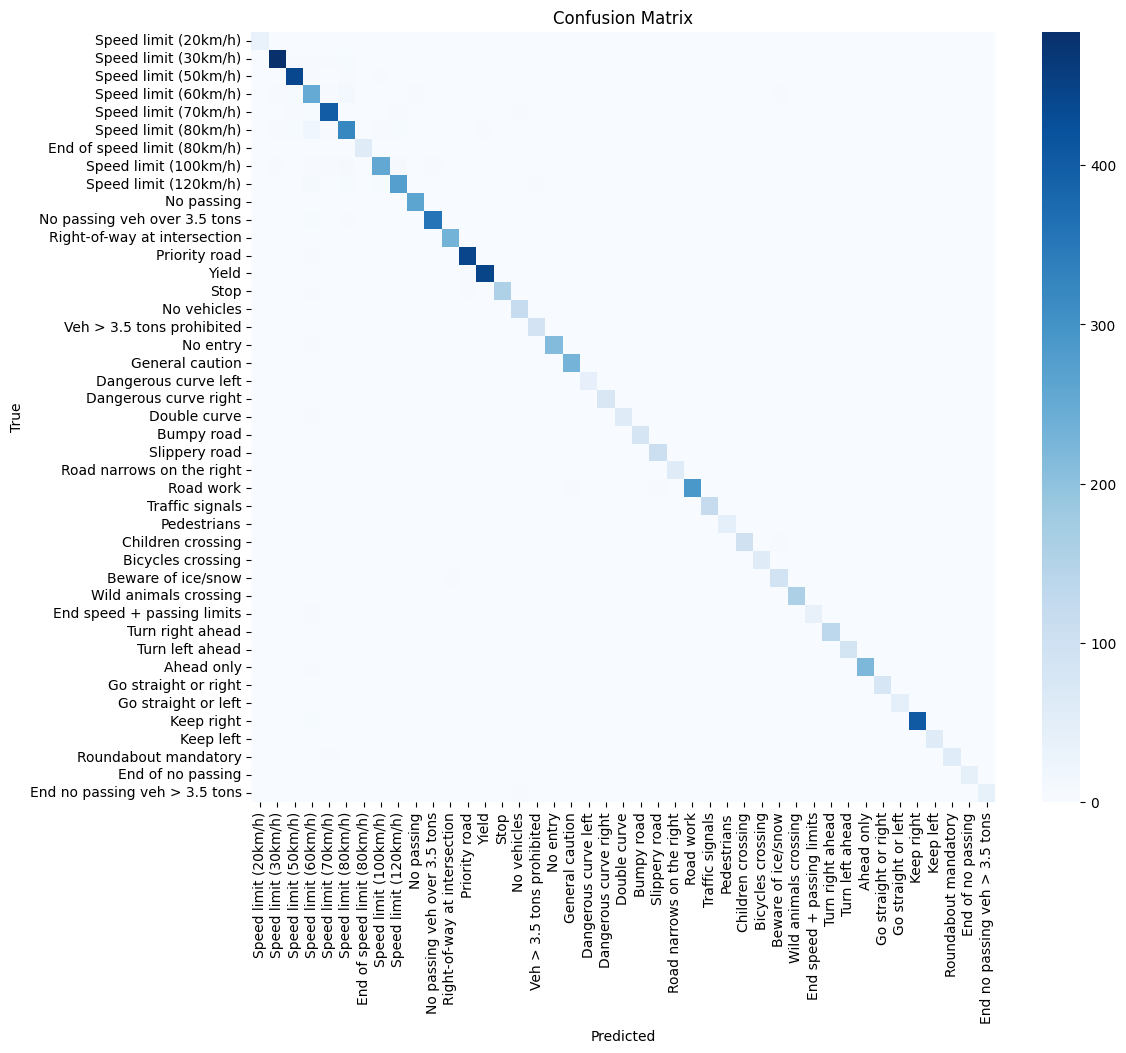

In [18]:
def test_model(model, data_loader, criterion, device, class_names=None):
    model.eval()
    val_loss = 0.0
    val_preds, val_targets = [], []

    # Torchmetrics
    accuracy_metric = MulticlassAccuracy(num_classes=num_classes, average="weighted").to(device)
    precision_metric = MulticlassPrecision(num_classes=num_classes, average="weighted").to(device)
    recall_metric = MulticlassRecall(num_classes=num_classes, average="weighted").to(device)
    f1_metric = MulticlassF1Score(num_classes=num_classes, average="weighted").to(device)

    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Testing", leave=False)
        for images, targets in progress_bar:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets.long())
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(targets.cpu().numpy())

            accuracy_metric.update(preds, targets)
            precision_metric.update(preds, targets)
            recall_metric.update(preds, targets)
            f1_metric.update(preds, targets)

    avg_val_loss = val_loss / len(data_loader)

    # Metrics
    val_accuracy = accuracy_metric.compute().item()
    val_precision = precision_metric.compute().item()
    val_recall = recall_metric.compute().item()
    val_f1 = f1_metric.compute().item()

    print("--------------- Test Set Performance ---------------")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Accuracy       : {val_accuracy:.4f}")
    print(f"Precision      : {val_precision:.4f}")
    print(f"Recall         : {val_recall:.4f}")
    print(f"F1 Score       : {val_f1:.4f}")

    # Reset metrics
    accuracy_metric.reset()
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()

    # Classification report (per class)
    if class_names:
        print("\n--------------- Classification Report ---------------")
        class_names = [IDX_TO_CLASS[i] for i in range(len(IDX_TO_CLASS))]
        print(classification_report(val_targets, val_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(val_targets, val_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    return avg_val_loss, val_accuracy, val_precision, val_recall, val_f1

val_loss, val_acc, val_prec, val_rec, val_f1 = test_model(model, test_loader, criterion, device, class_names=IDX_TO_CLASS)

> ## **save & Load model**

In [21]:
# 1. Define the model architecture again
loaded_model = CNNModel(num_classes)

# 2. Load the weights
# safer way
state_dict = torch.load("best_model.pth", weights_only=True)
loaded_model.load_state_dict(state_dict)

# 3. Send to device (GPU/CPU)
loaded_model = loaded_model.to(device)

# 4. Set to eval mode for inference
loaded_model.eval()

CNNModel(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16384, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=43, bias=True)
  )
)

> ## **Let's Check the Model Performance**

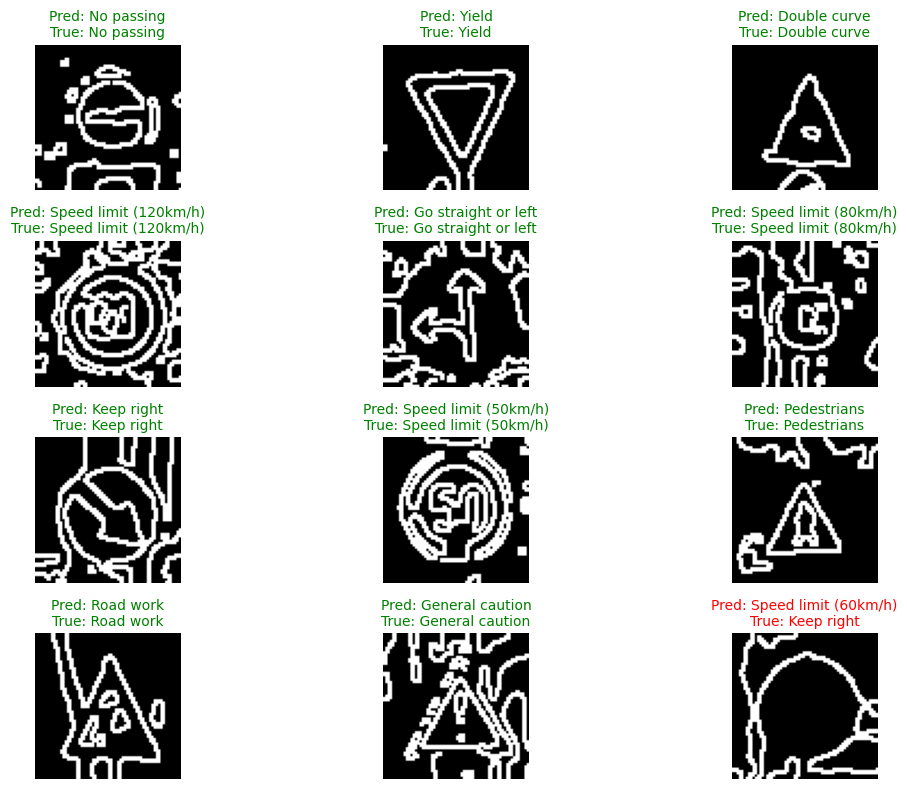

In [23]:
random_indices = random.sample(range(len(test_loader.dataset)), 12)
subset = Subset(test_loader.dataset, random_indices)
random_loader = DataLoader(subset, batch_size=1, shuffle=False)

model.eval()
fig, axes = plt.subplots(4, 3, figsize=(12, 8))
axs = axes.ravel()

with torch.no_grad():
    for i, (img, actual_label) in enumerate(random_loader):
        img = img.to(device)
        actual_label = int(actual_label.item())

        # forward pass
        output = model(img)
        prediction = int(output.argmax(dim=1).item())

        # Handle both grayscale (C=1) and RGB (C=3) images
        img_disp = (
            img.squeeze(0).cpu().numpy()
        )  # Remove batch dimension: (1, C, H, W) -> (C, H, W)

        if img_disp.shape[0] == 1:  # Grayscale image (1, H, W)
            img_disp = img_disp.squeeze(0)  # (H, W)
            cmap = "gray"
        else:  # RGB image (3, H, W)
            img_disp = np.transpose(img_disp, (1, 2, 0))  # CHW -> HWC
            cmap = None

        img_disp = np.clip(img_disp, 0, 1)

        # plot
        axs[i].imshow(img_disp, cmap=cmap)
        col = "green" if actual_label == prediction else "red"
        axs[i].set_title(
            f"Pred: {IDX_TO_CLASS[prediction]}\nTrue: {IDX_TO_CLASS[actual_label]}",
            color=col,
            fontsize=10,
        )
        axs[i].axis("off")

plt.tight_layout()
plt.show()

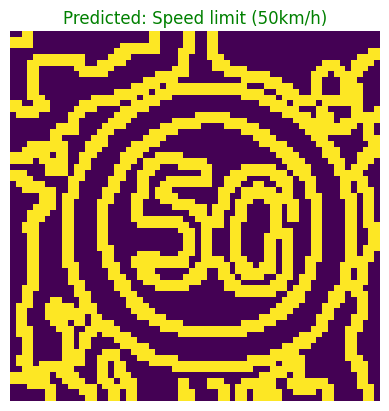

In [ ]:
image_path = input("Enter the path to the image: ")  # ex: "D:\Data_Science\1-MyProjects\3-DoneProjects\traffic sign recognition system\Data\Test\00034.png"
image = Image.open(image_path)

# Preprocessing
pre = PreProcess(size=image_size)
image_np = np.array(image)
processed_image_np = pre(image_np)

# Explicitly ensure the processed image is 1-channel (H, W) before converting to tensor
# The model expects input in (N, C, H, W) format, with C=1.
if processed_image_np.ndim == 3 and processed_image_np.shape[2] == 3:
    # If it's still 3-channel (H,W,3) from PreProcess, convert to grayscale
    # Note: cv2.cvtColor expects uint8 (0-255), so we denormalize temporarily.
    processed_image_np = cv2.cvtColor(
        (processed_image_np * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY
    )
elif processed_image_np.ndim == 3 and processed_image_np.shape[2] == 1:
    # If it's (H,W,1), squeeze the channel dimension to make it (H,W)
    processed_image_np = processed_image_np.squeeze(axis=2)

# Now, processed_image_np should be a 2D array (H, W)
# Convert to tensor: add channel dimension and batch dimension -> (1, 1, H, W)
preprocessed_img = (
    torch.from_numpy(processed_image_np).unsqueeze(0).unsqueeze(0).float()
)

# Send to device
device = "cuda" if torch.cuda.is_available() else "cpu"
img_for_model = preprocessed_img.to(device)

# Prediction
model.eval()
with torch.no_grad():
    output = model(img_for_model)
    prediction = int(output.argmax(dim=1).item())

# Visualization (needs to handle the 1-channel image correctly)
# preprocessed_img is (N, C, H, W), so squeeze to (H, W) for display
img_for_visualization = preprocessed_img.squeeze(0).squeeze(0).cpu().numpy()
img_for_visualization = np.clip(img_for_visualization, 0, 1)

plt.imshow(img_for_visualization)  # For grayscale -> cmap="gray"
plt.title(f"Predicted: {IDX_TO_CLASS[prediction]}", color="green")
plt.axis("off")
plt.show()

<div style="background: linear-gradient(135deg, #3B4953, #5A7863, #90AB8B, #EBF4DD); 
        color:rgba(26, 7, 7, 1); 
        width: 100%; 
        height: 50px; 
        text-align: center; 
        font-weight: bold; 
        line-height: 50px; 
        margin: 2 px 0; 
        font-size: 44px; 
        border-radius: 5px; ">
    Thanks for reading 😊
</div>